# Tennis Exploratory Data Analysis
---

Exploring [Jeff Sackmann tennis match repo](https://github.com/JeffSackmann/tennis_atp/blob/master)

## Imports

In [6]:
import pandas as pd
from io import StringIO
import requests
import re
import matplotlib.pyplot as plt
import warnings

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = None
warnings.filterwarnings("ignore")

## Reading repo content

In [7]:
# Function to list files in a GitHub repository
def list_github_files(repo_name: str) -> list:
    url = f"https://api.github.com/repos/{repo_name}/contents/"
    response = requests.get(url)
    if response.status_code == 200:
        files = response.json()
        file_names = [file["name"] for file in files]
        return file_names
    else:
        print(f"Failed to retrieve files: {response.status_code}")


repo_name = "JeffSackmann/tennis_atp"
file_names = list_github_files(repo_name)

In [8]:
# Filter files to only include CSV files
file_names = [file for file in file_names if file.endswith(".csv")]

In [9]:
# Filter files to only include those that follow the "atp_matches_YYYY" pattern
atp_matches = [file for file in file_names if re.match(r"atp_matches_\d{4}\.csv", file)]
# Filter files to only include those that start with "atp_rankings"
atp_rankings = [file for file in file_names if file.startswith("atp_rankings")]

In [10]:
print("Number of ATP Matches files:", len(atp_matches))
print("Number of ATP Rankings files:", len(atp_rankings))

Number of ATP Matches files: 57
Number of ATP Rankings files: 7


## Loading csv into DFs

In [11]:
def read_csv_from_github(repo_name: str, file_name: str) -> pd.DataFrame:
    """
    Reads a CSV file from a GitHub repository into a Pandas DataFrame.
    Parameters:
        repo_name (str): The name of the GitHub repository (e.g., "owner/repo").
        file_name (str): The name of the CSV file.
    Returns:
        pd.DataFrame: A Pandas DataFrame containing the data from the CSV file.
    """

    file_url = f"https://raw.githubusercontent.com/{repo_name}/master/{file_name}"
    response = requests.get(file_url, verify=False)
    csv_content = response.content.decode("utf-8")
    df = pd.read_csv(StringIO(csv_content))
    return df


# Read and aggregate ATP matches data
atp_matches_dfs = [read_csv_from_github(repo_name, file) for file in atp_matches]
atp_matches_df = pd.concat(atp_matches_dfs, ignore_index=True)

# Read and aggregate ATP rankings data
atp_rankings_dfs = [read_csv_from_github(repo_name, file) for file in atp_rankings]
atp_rankings_df = pd.concat(atp_rankings_dfs, ignore_index=True)

# Display df info for ATP matches and rankings
print(
    "ATP Matches DataFrame Info:",
    "\nShape:",
    atp_matches_df.shape,
    "\nColumns:",
    atp_matches_df.columns,
)
print(
    "ATP Rankings DataFrame Info:",
    "\nShape:",
    atp_rankings_df.shape,
    "\nColumns:",
    atp_rankings_df.columns,
)

ATP Matches DataFrame Info: 
Shape: (194996, 49) 
Columns: Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points'],
      dtype='object')
ATP Rankings DataFrame Info: 
Shape: (3292949, 4) 
Columns: Index(['ranking_date', 'rank', 'player', 'points'], dtype='object')


## ATP Ranking Exploration

In [12]:
# Create a DataFrame with unique players and their IDs
df_players = atp_matches_df.loc[:, ["winner_id", "winner_name"]].drop_duplicates()
df_players.columns = ["player_id", "player_name"]
df_players = pd.concat(
    [
        df_players,
        atp_matches_df.loc[:, ["loser_id", "loser_name"]]
        .drop_duplicates()
        .rename(columns={"loser_id": "player_id", "loser_name": "player_name"}),
    ],
    ignore_index=True,
)
df_players = df_players.drop_duplicates().reset_index(drop=True)

print("Number of unique players:", df_players.shape[0])
df_players.head()

Number of unique players: 7589


,player_id,player_name
0,112411,Doug Smith
1,126914,Louis Pretorius
2,209523,Cecil Pedlow
3,100084,Tom Okker
4,100132,Armistead Neely


In [13]:
# Add player names to the ATP rankings DataFrame
atp_rankings_df = atp_rankings_df.merge(
    df_players, how="left", left_on="player", right_on="player_id"
)

# Display the first few rows of the ATP rankings DataFrame
atp_rankings_df.head()

,ranking_date,rank,player,points,player_id,player_name
0,20000110,1,101736,4135.0,101736.0,Andre Agassi
1,20000110,2,102338,2915.0,102338.0,Yevgeny Kafelnikov
2,20000110,3,101948,2419.0,101948.0,Pete Sampras
3,20000110,4,103017,2184.0,103017.0,Nicolas Kiefer
4,20000110,5,102856,2169.0,102856.0,Gustavo Kuerten


In [14]:
# show oldest and newest ranking dates in a YYYY-MM-DD format and the name of the player with the highest ranking for each of these dates
atp_rankings_df["ranking_date"] = pd.to_datetime(
    atp_rankings_df["ranking_date"], format="%Y%m%d"
)
print(
    "Oldest ranking date:",
    atp_rankings_df["ranking_date"].min().strftime("%Y-%m-%d"),
    "\n",
    "Player with the highest ranking on this date:",
    atp_rankings_df[
        atp_rankings_df["ranking_date"] == atp_rankings_df["ranking_date"].min()
    ]
    .sort_values("rank", ascending=True)
    .iloc[0]["player_name"],
)
print(
    "Newest ranking date:",
    atp_rankings_df["ranking_date"].max().strftime("%Y-%m-%d"),
    "\n",
    "Player with the highest ranking on this date:",
    atp_rankings_df[
        atp_rankings_df["ranking_date"] == atp_rankings_df["ranking_date"].max()
    ]
    .sort_values("rank", ascending=True)
    .iloc[0]["player_name"],
)

Oldest ranking date: 1973-08-27 
 Player with the highest ranking on this date: Ilie Nastase
Newest ranking date: 2024-12-30 
 Player with the highest ranking on this date: Jannik Sinner


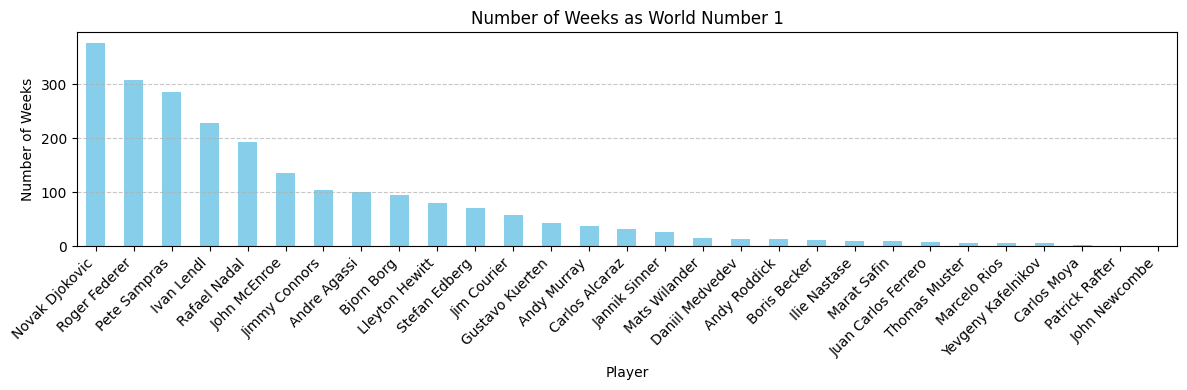

In [15]:
# Filter for rows where the rank is 1
number_one_rankings = atp_rankings_df[atp_rankings_df["rank"] == 1]

# Count the number of weeks each player has been number 1
number_one_weeks = number_one_rankings["player_name"].value_counts()

# Plot the number of weeks each player has been number 1
plt.figure(figsize=(12, 4))
number_one_weeks.plot(kind="bar", color="skyblue")
plt.title("Number of Weeks as World Number 1")
plt.xlabel("Player")
plt.ylabel("Number of Weeks")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

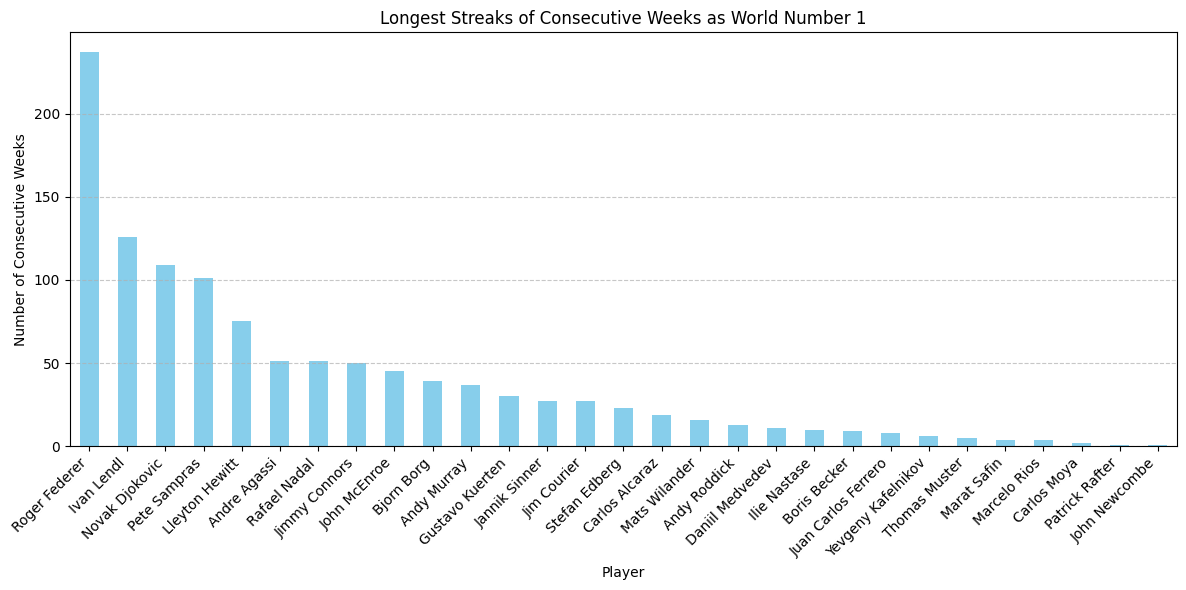

In [16]:

number_one_rankings = number_one_rankings.sort_values('ranking_date')
# Calculate the number of consecutive weeks each player has been number 1
number_one_rankings['prev_date'] = number_one_rankings['ranking_date'].shift(1)
number_one_rankings['prev_player'] = number_one_rankings['player_name'].shift(1)
number_one_rankings['consecutive'] = (number_one_rankings['player_name'] == number_one_rankings['prev_player'])

# Group by player and calculate the longest streak of consecutive weeks
number_one_rankings['streak_id'] = (~number_one_rankings['consecutive']).cumsum()
streaks = number_one_rankings.groupby(['player_name', 'streak_id']).size().reset_index(name='streak_length')

longest_streaks = streaks.groupby('player_name')['streak_length'].max().sort_values(ascending=False)

# Plot the longest streaks of consecutive weeks as number 1
plt.figure(figsize=(12, 6))
longest_streaks.plot(kind='bar', color='skyblue')
plt.title('Longest Streaks of Consecutive Weeks as World Number 1')
plt.xlabel('Player')
plt.ylabel('Number of Consecutive Weeks')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [17]:
# Check for missing weeks in the ATP rankings DataFrame
all_weeks = pd.date_range(
    start=atp_rankings_df["ranking_date"].min(),
    end=atp_rankings_df["ranking_date"].max(),
    freq="W-MON",
)
missing_weeks = all_weeks.difference(atp_rankings_df["ranking_date"].unique())

print(f"Number of missing weeks in ATP rankings: {len(missing_weeks)}")
print("Missing weeks:", missing_weeks)

Number of missing weeks in ATP rankings: 422
Missing weeks: DatetimeIndex(['1973-09-03', '1973-09-10', '1973-09-24', '1973-10-08',
               '1973-10-22', '1973-10-29', '1973-11-12', '1973-11-19',
               '1973-12-03', '1973-12-10',
               ...
               '2023-10-09', '2024-01-22', '2024-03-11', '2024-03-25',
               '2024-04-29', '2024-05-13', '2024-06-03', '2024-07-08',
               '2024-09-02', '2024-10-07'],
              dtype='datetime64[ns]', length=422, freq=None)


**Warning:** Some weeks are missing from ATP Rankings

## ATP Matches Exploration

In [18]:
# Convert the 'tourney_date' column to datetime format
atp_matches_df["tourney_date"] = pd.to_datetime(
    atp_matches_df["tourney_date"], format="%Y%m%d"
)

atp_matches_df.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,1968-2029,Dublin,Grass,32.0,A,1968-07-08,270,112411,NaN,NaN,Doug Smith,U,NaN,AUS,NaN,110196,NaN,NaN,Peter Ledbetter,U,NaN,IRL,24.0,6-1 7-5,3,R32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1968-2029,Dublin,Grass,32.0,A,1968-07-08,271,126914,NaN,NaN,Louis Pretorius,R,NaN,RSA,NaN,209536,NaN,NaN,Maurice Pollock,U,NaN,IRL,NaN,6-1 6-1,3,R32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1968-2029,Dublin,Grass,32.0,A,1968-07-08,272,209523,NaN,NaN,Cecil Pedlow,U,NaN,IRL,NaN,209535,NaN,NaN,John Mulvey,U,NaN,IRL,NaN,6-2 6-2,3,R32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1968-2029,Dublin,Grass,32.0,A,1968-07-08,273,100084,NaN,NaN,Tom Okker,R,178.0,NED,24.3,209534,NaN,NaN,Unknown Fearmon,U,NaN,NaN,NaN,6-1 6-1,3,R32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1968-2029,Dublin,Grass,32.0,A,1968-07-08,274,100132,NaN,NaN,Armistead Neely,R,NaN,USA,21.3,209533,NaN,NaN,Harry Sheridan,U,NaN,IRL,NaN,6-2 6-4,3,R32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
atp_matches_df.describe()

,draw_size,tourney_date,match_num,winner_id,winner_seed,winner_ht,winner_age,loser_id,loser_seed,loser_ht,loser_age,best_of,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
count,194161.000000,194996,194996.000000,194996.000000,72220.000000,178366.000000,193687.000000,194996.000000,36856.000000,165802.000000,190348.000000,194996.000000,95105.000000,98051.000000,98050.000000,98050.000000,98050.000000,98050.000000,98050.000000,98050.000000,98050.000000,98050.000000,98050.000000,98051.000000,98050.000000,98050.000000,98050.000000,98050.000000,98050.000000,98050.000000,98050.000000,159221.000000,111998.000000,150826.000000,110346.000000
mean,53.244071,1994-08-01 11:07:35.861658624,82.140567,105319.932209,6.340612,184.573349,25.681538,106464.189850,7.754287,184.318808,25.737202,3.436214,104.307586,6.553008,2.719857,78.113177,47.720571,35.992830,16.693983,12.412320,3.519623,5.149954,4.863967,3.463290,80.955421,48.160765,32.025273,14.958287,12.211025,4.806456,8.717348,75.355512,1391.060956,112.850828,875.078027
min,2.000000,1967-12-28 00:00:00,1.000000,100001.000000,1.000000,3.000000,14.300000,100001.000000,1.000000,3.000000,14.200000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,32.000000,1980-07-14 00:00:00,11.000000,100434.000000,2.000000,180.000000,22.700000,100532.000000,4.000000,180.000000,22.700000,3.000000,75.000000,3.000000,1.000000,56.000000,34.000000,26.000000,12.000000,9.000000,1.000000,2.000000,2.000000,2.000000,59.000000,34.000000,22.000000,10.000000,9.000000,2.000000,6.000000,17.000000,499.000000,36.000000,369.000000
50%,32.000000,1993-10-04 00:00:00,26.000000,101746.000000,5.000000,185.000000,25.300000,101962.000000,6.000000,185.000000,25.400000,3.000000,97.000000,5.000000,2.000000,73.000000,44.000000,33.000000,16.000000,11.000000,3.000000,4.000000,4.000000,3.000000,76.000000,45.000000,30.000000,14.000000,11.000000,4.000000,8.000000,45.000000,855.000000,70.000000,641.000000
75%,64.000000,2007-12-31 00:00:00,105.000000,104098.000000,8.000000,188.000000,28.200000,104523.000000,10.000000,188.000000,28.400000,3.000000,126.000000,9.000000,4.000000,94.000000,58.000000,43.000000,21.000000,15.000000,5.000000,7.000000,7.000000,5.000000,97.000000,58.000000,40.000000,19.000000,15.000000,7.000000,11.000000,86.000000,1556.000000,118.000000,1023.000000
max,128.000000,2024-12-18 00:00:00,1701.000000,212721.000000,35.000000,211.000000,58.700000,212970.000000,35.000000,211.000000,63.600000,5.000000,1146.000000,113.000000,26.000000,491.000000,361.000000,292.000000,82.000000,90.000000,24.000000,34.000000,103.000000,26.000000,489.000000,328.000000,284.000000,101.000000,91.000000,28.000000,38.000000,2101.000000,16950.000000,2159.000000,16950.000000
std,36.816886,NaN,113.867026,16049.732171,5.590401,6.784395,4.059004,18507.575749,6.113619,6.764151,4.204585,0.826817,39.728154,5.332952,2.360314,29.477473,19.203273,13.822754,6.973109,4.122487,3.082269,4.055242,4.682426,2.612516,29.410246,19.368837,14.443147,7.199712,4.130895,3.275843,4.134125,121.346354,1745.290816,162.782552,1004.867999


In [20]:
# Count the number of NaN values for each column in the ATP matches DataFrame
nan_counts_matches = atp_matches_df.isna().sum() / atp_matches_df.shape[0] * 100
print("NaN % in ATP matches DataFrame:")
print(nan_counts_matches)

NaN % in ATP matches DataFrame:
tourney_id             0.000000
tourney_name           0.000000
surface                1.533365
draw_size              0.428214
tourney_level          0.000000
tourney_date           0.000000
match_num              0.000000
winner_id              0.000000
winner_seed           62.963343
winner_entry          91.169050
winner_name            0.000000
winner_hand            0.001538
winner_ht              8.528380
winner_ioc             0.004103
winner_age             0.671296
loser_id               0.000000
loser_seed            81.099099
loser_entry           85.055078
loser_name             0.000000
loser_hand             0.005641
loser_ht              14.971589
loser_ioc              0.036924
loser_age              2.383639
score                  0.004615
best_of                0.000000
round                  0.000000
minutes               51.227205
w_ace                 49.716404
w_df                  49.716917
w_svpt                49.716917
w_1stIn 

In [21]:
# Check the oldest and newest match and display winner and loser names for each of these matches
oldest_match = atp_matches_df.loc[atp_matches_df["tourney_date"].idxmin()]
newest_match = atp_matches_df.loc[atp_matches_df["tourney_date"].idxmax()]

print("Oldest match:")
print(f"Date: {oldest_match['tourney_date'].strftime('%Y-%m-%d')}")
print(f"Winner: {oldest_match['winner_name']}")
print(f"Loser: {oldest_match['loser_name']}")

print("\nNewest match:")
print(f"Date: {newest_match['tourney_date'].strftime('%Y-%m-%d')}")
print(f"Winner: {newest_match['winner_name']}")
print(f"Loser: {newest_match['loser_name']}")

Oldest match:
Date: 1967-12-28
Winner: Alex Metreveli
Loser: Jan Kodes

Newest match:
Date: 2024-12-18
Winner: Joao Fonseca
Loser: Learner Tien


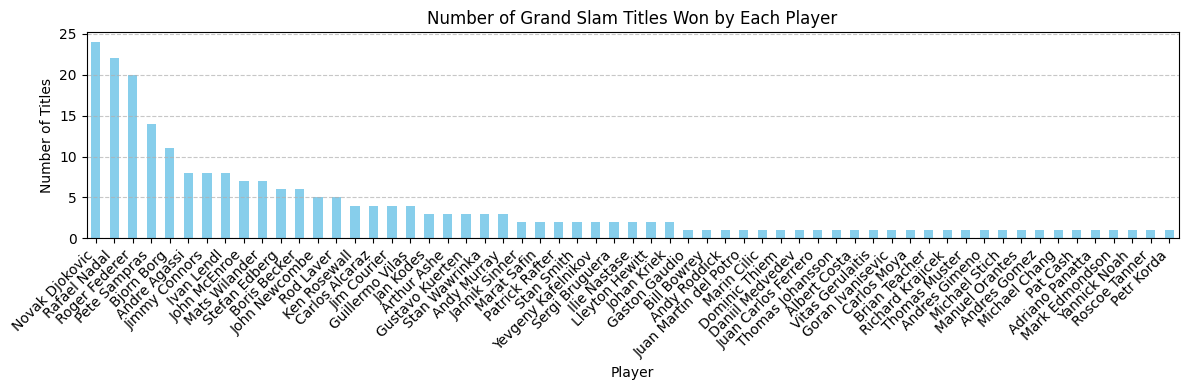

In [22]:
# Most Grand Slam titles won by a player
grand_slam_titles = atp_matches_df.loc[
    (atp_matches_df["tourney_level"] == "G") & (atp_matches_df["round"] == "F"),
    "winner_name",
].value_counts()

# Plot the number of Grand Slam titles won by each player
plt.figure(figsize=(12, 4))
grand_slam_titles.plot(kind="bar", color="skyblue")
plt.title("Number of Grand Slam Titles Won by Each Player")
plt.xlabel("Player")
plt.ylabel("Number of Titles")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

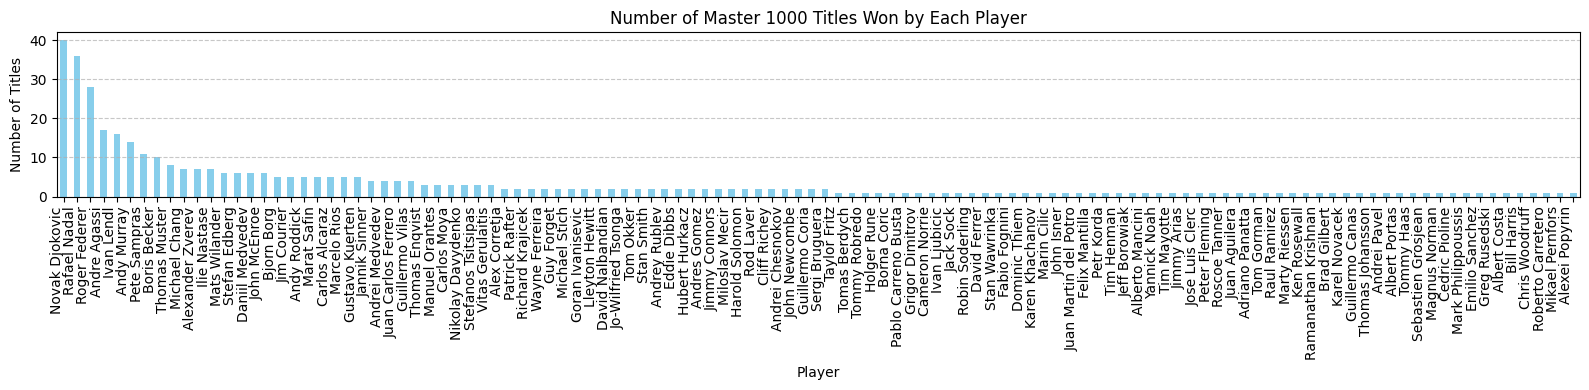

In [23]:
# Most Master 1000 titles won by a player
master_1000_titles = atp_matches_df.loc[
    (atp_matches_df["tourney_level"] == "M") & (atp_matches_df["round"] == "F"),
    "winner_name",
].value_counts()

# Plot the number of Master 1000 titles won by each player
plt.figure(figsize=(16, 4))
master_1000_titles.plot(kind="bar", color="skyblue")
plt.title("Number of Master 1000 Titles Won by Each Player")
plt.xlabel("Player")
plt.ylabel("Number of Titles")
plt.xticks(rotation=90, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [24]:
# Create tournay_year column
atp_matches_df["tourney_year"] = atp_matches_df["tourney_date"].dt.year
# Display number of NaN values in % in w_ace column per year
ace_nan_by_year = atp_matches_df.groupby("tourney_year")["w_ace"].apply(
    lambda x: x.isna().sum() / x.shape[0] * 100
)

print(ace_nan_by_year)

tourney_year
1967    100.000000
1968    100.000000
1969    100.000000
1970    100.000000
1971    100.000000
1972    100.000000
1973    100.000000
1974    100.000000
1975     99.976162
1976    100.000000
1977    100.000000
1978    100.000000
1979    100.000000
1980    100.000000
1981    100.000000
1982    100.000000
1983    100.000000
1984    100.000000
1985    100.000000
1986    100.000000
1987    100.000000
1988    100.000000
1989    100.000000
1990     98.397008
1991     13.254628
1992     11.099196
1993     10.462725
1994     11.630269
1995     11.184211
1996     11.730970
1997     11.176636
1998     10.192147
1999     11.727654
2000     12.907046
2001     10.000000
2002     11.577965
2003     13.088000
2004     12.408759
2005     10.784314
2006     10.988675
2007     11.750381
2008     11.782178
2009     11.636953
2010     11.353135
2011     10.878939
2012     10.633484
2013     11.277174
2014     11.576705
2015     10.975195
2016      0.850051
2017      1.408451
2018      1.207243

In [25]:
# Filter for matches after selected year
selected_year = 1991
atp_matches_df = atp_matches_df[
    atp_matches_df["tourney_year"] >= selected_year
].reset_index(drop=True)
# Filter for tourney levels in ['G', 'F', 'M', 'A']
atp_matches_df = atp_matches_df[
    atp_matches_df["tourney_level"].isin(["G", "F", "M", "A"])
].reset_index(drop=True)
# Exclude Laver Cup matches
atp_matches_df = atp_matches_df[
    ~atp_matches_df["tourney_name"].str.contains("Laver Cup")
].reset_index(drop=True)

# Count the number of NaN values for each column in the ATP matches DataFrame
nan_counts_matches = atp_matches_df.isna().sum() / atp_matches_df.shape[0] * 100
print("Dataframe shape: ", atp_matches_df.shape)
print("NaN % in ATP matches DataFrame from {}:".format(selected_year))
print(nan_counts_matches)

Dataframe shape:  (98355, 50)
NaN % in ATP matches DataFrame from 1991:
tourney_id             0.000000
tourney_name           0.000000
surface                0.000000
draw_size              0.000000
tourney_level          0.000000
tourney_date           0.000000
match_num              0.000000
winner_id              0.000000
winner_seed           55.391185
winner_entry          86.417569
winner_name            0.000000
winner_hand            0.000000
winner_ht              0.095572
winner_ioc             0.000000
winner_age             0.000000
loser_id               0.000000
loser_seed            75.417620
loser_entry           77.741853
loser_name             0.000000
loser_hand             0.000000
loser_ht               0.721875
loser_ioc              0.000000
loser_age              0.012201
score                  0.000000
best_of                0.000000
round                  0.000000
minutes                4.663718
w_ace                  1.810787
w_df                   1.810787


**Comment:** It seems like after 1991 data has less blanks, probably this is a good cutoff date.

## NaN management for ATP Matches

After keeping matches after 1991, let's try to see if some NaN values could be filled

In [26]:
atp_matches_df.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_year
0,1991-301,Auckland,Hard,32.0,A,1991-01-07,1,101142,1.0,NaN,Emilio Sanchez,R,180.0,ESP,25.6,101746,NaN,NaN,Renzo Furlan,R,175.0,ITA,20.6,6-4 6-1,3,R32,63.0,1.0,0.0,53.0,37.0,30.0,7.0,9.0,5.0,6.0,3.0,0.0,46.0,30.0,17.0,7.0,8.0,2.0,6.0,9.0,1487.0,78.0,459.0,1991
1,1991-301,Auckland,Hard,32.0,A,1991-01-07,2,101613,NaN,Q,Malivai Washington,R,180.0,USA,21.5,100587,NaN,WC,Steve Guy,R,188.0,NZL,31.8,6-3 6-2,3,R32,72.0,5.0,1.0,56.0,25.0,17.0,20.0,9.0,1.0,2.0,4.0,7.0,56.0,30.0,22.0,6.0,8.0,7.0,11.0,94.0,371.0,220.0,114.0,1991
2,1991-301,Auckland,Hard,32.0,A,1991-01-07,3,101179,NaN,NaN,Jean Philippe Fleurian,R,185.0,FRA,25.3,101601,NaN,WC,Brett Steven,R,185.0,NZL,21.6,2-6 6-1 6-2,3,R32,101.0,2.0,4.0,80.0,55.0,35.0,16.0,12.0,2.0,4.0,1.0,3.0,68.0,43.0,24.0,14.0,11.0,4.0,8.0,77.0,468.0,212.0,116.0,1991
3,1991-301,Auckland,Hard,32.0,A,1991-01-07,4,101117,NaN,NaN,Eric Jelen,R,180.0,GER,25.8,101332,8.0,NaN,Gilad Bloom,L,173.0,ISR,23.8,6-3 1-6 6-4,3,R32,108.0,0.0,1.0,82.0,55.0,35.0,14.0,13.0,6.0,10.0,3.0,2.0,96.0,61.0,38.0,15.0,13.0,8.0,12.0,65.0,502.0,72.0,483.0,1991
4,1991-301,Auckland,Hard,32.0,A,1991-01-07,5,101901,NaN,Q,Chuck Adams,R,185.0,USA,19.7,101735,3.0,NaN,Richard Fromberg,R,196.0,AUS,20.6,6-3 6-4,3,R32,65.0,4.0,4.0,65.0,46.0,34.0,12.0,10.0,2.0,2.0,1.0,3.0,49.0,25.0,21.0,12.0,9.0,4.0,6.0,190.0,142.0,28.0,876.0,1991


In [27]:
# show records with NaN values in the 'winner_ht' column
players_noheight = list(
    atp_matches_df.loc[atp_matches_df["winner_ht"].isna(), "winner_name"].unique()
)
players_noheight.append(
    atp_matches_df.loc[atp_matches_df["loser_ht"].isna(), "loser_name"].unique()
)
# flatten the list
players_noheight = [item for sublist in players_noheight for item in sublist]
# remove duplicates
players_noheight = list(set(players_noheight))

# Create a dataframe with players with height
df_players_height = atp_matches_df.loc[
    :, ["winner_name", "winner_ht"]
].drop_duplicates()
df_players_height.columns = ["player_name", "height"]
df_players_height = pd.concat(
    [
        df_players_height,
        atp_matches_df.loc[:, ["loser_name", "loser_ht"]]
        .drop_duplicates()
        .rename(columns={"loser_name": "player_name", "loser_ht": "height"}),
    ],
    ignore_index=True,
)
df_players_height = df_players_height.drop_duplicates().reset_index(drop=True)

# check if players with missing height values are in the df_players_height dataframe
df_players_height = df_players_height[
    df_players_height["player_name"].isin(players_noheight)
    & ~df_players_height["height"].isna()
].reset_index(drop=True)

In [28]:
# Fill NaN values in the 'winner_ht' and 'loser_ht' columns with value from df_players_height
atp_matches_df = atp_matches_df.merge(
    df_players_height, how="left", left_on="winner_name", right_on="player_name"
)
atp_matches_df["winner_ht"] = atp_matches_df["winner_ht"].fillna(
    atp_matches_df["height"]
)
atp_matches_df = atp_matches_df.drop(columns=["player_name", "height"])

atp_matches_df = atp_matches_df.merge(
    df_players_height, how="left", left_on="loser_name", right_on="player_name"
)
atp_matches_df["loser_ht"] = atp_matches_df["loser_ht"].fillna(atp_matches_df["height"])
atp_matches_df = atp_matches_df.drop(columns=["player_name", "height"])

# Count the number of NaN values for each column in the ATP matches DataFrame
nan_counts_matches = atp_matches_df.isna().sum() / atp_matches_df.shape[0] * 100
print("NaN % in ATP matches DataFrame after filling height values:")
print(nan_counts_matches)

NaN % in ATP matches DataFrame after filling height values:
tourney_id             0.000000
tourney_name           0.000000
surface                0.000000
draw_size              0.000000
tourney_level          0.000000
tourney_date           0.000000
match_num              0.000000
winner_id              0.000000
winner_seed           55.391185
winner_entry          86.417569
winner_name            0.000000
winner_hand            0.000000
winner_ht              0.095572
winner_ioc             0.000000
winner_age             0.000000
loser_id               0.000000
loser_seed            75.417620
loser_entry           77.741853
loser_name             0.000000
loser_hand             0.000000
loser_ht               0.721875
loser_ioc              0.000000
loser_age              0.012201
score                  0.000000
best_of                0.000000
round                  0.000000
minutes                4.663718
w_ace                  1.810787
w_df                   1.810787
w_svpt      

In [29]:
# Filter for columns with less than 50 NaN values
cols_to_keep = [
    col
    for col in atp_matches_df.columns
    if col not in list(nan_counts_matches[nan_counts_matches > 50].index)
]
# Filter the ATP matches DataFrame
atp_matches_df = atp_matches_df[cols_to_keep]

## Prepare DF for modeling: Goal 1, tournaments favorites

based on:
- tournament info: surface, draw_size, tourney_level, best_of, 
- player info: ioc, ht, hand
- players stats 10 last matches:
    - number of victory
    - number of losses
    - number of set win
    - number of set loss
    - player age at tourney date
    - player ranking at tourney date
    - player ranking point at tourney date
    - avg:
        - minutes played
        - ace                  
        - df
        - svpt   
        - 1stIn  
        - 1stWon 
        - 2ndWon 
        - SvGms  
        - bpSaved
        - bpFaced


### Tournament Info DF

In [30]:
# Create a tournament DataFrame
df_tournaments = (
    atp_matches_df.loc[
        :,
        [
            "tourney_id",
            "tourney_name",
            "surface",
            "draw_size",
            "tourney_level",
            "tourney_date",
            "best_of",
            "tourney_year",
        ],
    ]
    .drop_duplicates()
    .reset_index(drop=True)
)
df_tournaments.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,best_of,tourney_year
0,1991-301,Auckland,Hard,32.0,A,1991-01-07,3,1991
1,1991-338,Sydney Outdoor,Hard,32.0,A,1991-01-07,3,1991
2,1991-580,Australian Open,Hard,128.0,G,1991-01-14,5,1991
3,1991-201,Guaruja,Hard,32.0,A,1991-02-04,3,1991
4,1991-408,Milan,Carpet,32.0,A,1991-02-04,3,1991


### Player Info DF

In [31]:
# Create a player info DataFrame
df_players_info = atp_matches_df.loc[
    :, ["winner_id", "winner_name", "winner_hand", "winner_ht", "winner_ioc"]
].drop_duplicates()
df_players_info.columns = ["player_id", "player_name", "hand", "height", "country"]
df_players_info = pd.concat(
    [
        df_players_info,
        atp_matches_df.loc[
            :, ["loser_id", "loser_name", "loser_hand", "loser_ht", "loser_ioc"]
        ]
        .drop_duplicates()
        .rename(
            columns={
                "loser_id": "player_id",
                "loser_name": "player_name",
                "loser_hand": "hand",
                "loser_ht": "height",
                "loser_ioc": "country",
            }
        ),
    ],
    ignore_index=True,
)

df_players_info = df_players_info.drop_duplicates().reset_index(drop=True)
df_players_info.head()


,player_id,player_name,hand,height,country
0,101142,Emilio Sanchez,R,180.0,ESP
1,101613,Malivai Washington,R,180.0,USA
2,101179,Jean Philippe Fleurian,R,185.0,FRA
3,101117,Eric Jelen,R,180.0,GER
4,101901,Chuck Adams,R,185.0,USA


### Player Stats DF

In [32]:
# create winner and loser counter columns
atp_matches_df["winner_counter"] = atp_matches_df.groupby("winner_name").cumcount() + 1

atp_matches_df["loser_counter"] = atp_matches_df.groupby("loser_name").cumcount() + 1

In [33]:
# Create a DataFrame with player match statistics by tourney date
df_player_stats = (
    atp_matches_df.groupby(["winner_name", "tourney_date"])
    .agg(
        {
            "winner_counter": "max",
            "winner_age": "min",
            "minutes": [
                ("min_minutes", "min"),
                ("mean_minutes", "mean"),
                ("max_minutes", "max"),
            ],
            "w_ace": "mean",
            "w_df": "mean",
            "w_svpt": "mean",
            "w_1stIn": "mean",
            "w_1stWon": "mean",
            "w_2ndWon": "mean",
            "w_SvGms": "mean",
            "w_bpSaved": "mean",
            "w_bpFaced": "mean",
            "winner_rank": "min",
        }
    )
    .reset_index()
)
# remove multiindex and concatenate column names
df_player_stats.columns = [
    "_".join(col).strip() for col in df_player_stats.columns.values
]
# rename columns
df_player_stats.columns = [
    "player_name",
    "tourney_date",
    "winner_counter",
    "age",
    "min_minutes",
    "mean_minutes",
    "max_minutes",
    "ace_mean",
    "df_mean",
    "svpt_mean",
    "1stIn_mean",
    "1stWon_mean",
    "2ndWon_mean",
    "SvGms_mean",
    "bpSaved_mean",
    "bpFaced_mean",
    "rank",
]

# Repeat the same for losers
df_loser_stats = (
    atp_matches_df.groupby(["loser_name", "tourney_date"])
    .agg(
        {
            "loser_counter": "max",
            "loser_age": "min",
            "minutes": [
                ("min_minutes", "min"),
                ("mean_minutes", "mean"),
                ("max_minutes", "max"),
            ],
            "l_ace": "mean",
            "l_df": "mean",
            "l_svpt": "mean",
            "l_1stIn": "mean",
            "l_1stWon": "mean",
            "l_2ndWon": "mean",
            "l_SvGms": "mean",
            "l_bpSaved": "mean",
            "l_bpFaced": "mean",
            "loser_rank": "min",
        }
    )
    .reset_index()
)
df_loser_stats.columns = [
    "_".join(col).strip() for col in df_loser_stats.columns.values
]
df_loser_stats.columns = [
    "player_name",
    "tourney_date",
    "loser_counter",
    "age",
    "min_minutes",
    "mean_minutes",
    "max_minutes",
    "ace_mean",
    "df_mean",
    "svpt_mean",
    "1stIn_mean",
    "1stWon_mean",
    "2ndWon_mean",
    "SvGms_mean",
    "bpSaved_mean",
    "bpFaced_mean",
    "rank",
]

In [34]:
# Merge the winner and loser statistics DataFrames
df_player_stats = (
    pd.concat([df_player_stats, df_loser_stats], ignore_index=True)
    .sort_values(["player_name", "tourney_date"])
    .reset_index(drop=True)
)

# Group by player name and tourney date
df_player_stats = (
    df_player_stats.groupby(["player_name", "tourney_date"])
    .agg(
        {
            "winner_counter": "sum",
            "loser_counter": "sum",
            "age": "min",
            "min_minutes": "min",
            "mean_minutes": "mean",
            "max_minutes": "max",
            "ace_mean": "mean",
            "df_mean": "mean",
            "svpt_mean": "mean",
            "1stIn_mean": "mean",
            "1stWon_mean": "mean",
            "2ndWon_mean": "mean",
            "SvGms_mean": "mean",
            "bpSaved_mean": "mean",
            "bpFaced_mean": "mean",
            "rank": "min",
        }
    )
    .reset_index()
)

In [35]:
# Adjusting for tournaments in which a player played only one match
# Replace 0 values with NaN in 'winner_counter' and 'loser_counter' columns
df_player_stats["winner_counter"] = df_player_stats["winner_counter"].replace(0, None)
df_player_stats["loser_counter"] = df_player_stats["loser_counter"].replace(0, None)

# Fill NaN values in 'winner_counter' and 'loser_counter' columns with the previous non-NaN value
df_player_stats["winner_counter"] = (
    df_player_stats.groupby("player_name")["winner_counter"].ffill().fillna(0)
)
df_player_stats["loser_counter"] = (
    df_player_stats.groupby("player_name")["loser_counter"].ffill().fillna(0)
)

# Adding win percentage column
df_player_stats["win_percentage"] = df_player_stats["winner_counter"] / (
    df_player_stats["winner_counter"] + df_player_stats["loser_counter"]
)

# Shift tourney_date and rank columns by one row, to get stats at the beginning of the next tournament
df_player_stats["tourney_date_next"] = df_player_stats.groupby("player_name")[
    "tourney_date"
].shift(-1)
df_player_stats["rank_next"] = df_player_stats.groupby("player_name")["rank"].shift(-1)

In [36]:
# Group by player name and tourney date and calculate some stats of last 5 tourneys
cols_to_avg = [
    "mean_minutes",
    "ace_mean",
    "df_mean",
    "svpt_mean",
    "1stIn_mean",
    "1stWon_mean",
    "2ndWon_mean",
    "SvGms_mean",
    "bpSaved_mean",
    "bpFaced_mean",
]

for col in cols_to_avg:
    df_player_stats[f"mean_{col}_l5"] = df_player_stats.groupby("player_name")[
        col
    ].transform(lambda x: x.rolling(5, min_periods=1).mean())


df_player_stats["min_minutes_l5"] = df_player_stats.groupby("player_name")[
    "min_minutes"
].transform(lambda x: x.rolling(5, min_periods=1).min())
df_player_stats["max_minutes_l5"] = df_player_stats.groupby("player_name")[
    "max_minutes"
].transform(lambda x: x.rolling(5, min_periods=1).max())

In [37]:
# Fill tourney_date_next with the week after the last tourney_date_next available
df_player_stats["tourney_date_next"] = df_player_stats.groupby("player_name")[
    "tourney_date_next"
].fillna(df_player_stats["tourney_date"] + pd.DateOffset(7))
# Fill rank_next with the last rank available
df_player_stats["rank_next"] = df_player_stats.groupby("player_name")[
    "rank_next"
].fillna(method="ffill")

In [38]:
df_player_stats.head()

,player_name,tourney_date,winner_counter,loser_counter,age,min_minutes,mean_minutes,max_minutes,ace_mean,df_mean,svpt_mean,1stIn_mean,1stWon_mean,2ndWon_mean,SvGms_mean,bpSaved_mean,bpFaced_mean,rank,win_percentage,tourney_date_next,rank_next,mean_mean_minutes_l5,mean_ace_mean_l5,mean_df_mean_l5,mean_svpt_mean_l5,mean_1stIn_mean_l5,mean_1stWon_mean_l5,mean_2ndWon_mean_l5,mean_SvGms_mean_l5,mean_bpSaved_mean_l5,mean_bpFaced_mean_l5,min_minutes_l5,max_minutes_l5
0,Aaron Krickstein,1991-01-07,1.0,1.0,23.4,92.0,111.0,130.0,2.00,1.000000,94.000000,56.5,38.500000,23.000000,13.500000,6.000000,7.500000,20.0,0.500000,1991-01-14,22.0,111.000000,2.0000,1.000000,94.000000,56.500,38.500000,23.000000,13.500000,6.000000,7.500000,92.0,130.0
1,Aaron Krickstein,1991-01-14,4.0,2.0,23.4,110.0,121.0,165.0,4.50,2.166667,96.666667,58.5,36.333333,16.333333,14.333333,6.166667,11.666667,22.0,0.666667,1991-02-04,20.0,116.000000,3.2500,1.583333,95.333333,57.500,37.416667,19.666667,13.916667,6.083333,9.583333,92.0,165.0
2,Aaron Krickstein,1991-02-04,6.0,3.0,23.5,9.0,58.5,88.0,1.75,1.000000,45.000000,27.5,19.250000,10.250000,8.000000,1.250000,3.000000,20.0,0.666667,1991-03-15,25.0,96.833333,2.7500,1.388889,78.555556,47.500,31.361111,16.527778,11.944444,4.472222,7.388889,9.0,165.0
3,Aaron Krickstein,1991-03-15,6.0,4.0,23.6,64.0,64.0,64.0,6.00,4.000000,58.000000,28.0,20.000000,11.000000,9.000000,5.000000,9.000000,25.0,0.600000,1991-04-01,29.0,88.625000,3.5625,2.041667,73.416667,42.625,28.520833,15.145833,11.208333,4.604167,7.791667,9.0,165.0
4,Aaron Krickstein,1991-04-01,6.0,5.0,23.6,87.0,87.0,87.0,8.00,5.000000,77.000000,51.0,33.000000,11.000000,9.000000,8.000000,10.000000,29.0,0.545455,1991-04-08,29.0,88.300000,4.4500,2.633333,74.133333,44.300,29.416667,14.316667,10.766667,5.283333,8.233333,9.0,165.0


### Create our model DataFrame

In [39]:
# Create tournament partecipants DataFrames, which then will become our model df
loser_partecipants = atp_matches_df.loc[
    :, ["tourney_id", "tourney_name", "tourney_date", "loser_name"]
].drop_duplicates()
winner_partecipants = atp_matches_df.loc[
    :, ["tourney_id", "tourney_name", "tourney_date", "winner_name"]
].drop_duplicates()

loser_partecipants.columns = [
    "tourney_id",
    "tourney_name",
    "tourney_date",
    "player_name",
]
winner_partecipants.columns = [
    "tourney_id",
    "tourney_name",
    "tourney_date",
    "player_name",
]

df_model = (
    pd.concat([winner_partecipants, loser_partecipants], ignore_index=True)
    .drop_duplicates()
    .reset_index(drop=True)
)

In [40]:
# Get the winner for each tournament
df_winners = atp_matches_df.loc[
    atp_matches_df["round"] == "F",
    ["tourney_id", "tourney_name", "tourney_date", "winner_name"],
].reset_index(drop=True)

In [41]:
# Add tourney winners to the model DataFrame
df_model = df_model.merge(
    df_winners, how="left", on=["tourney_id", "tourney_name", "tourney_date"]
)
# create the target variable: 1 if the player is the winner, 0 otherwise
df_model["is_winner"] = (df_model["player_name"] == df_model["winner_name"]).astype(int)

In [42]:
# Add Tourney Info to the model DataFrame
df_model = df_model.merge(
    df_tournaments, how="left", on=["tourney_id", "tourney_name", "tourney_date"]
)

# Add Player Info to the model DataFrame
df_model = df_model.merge(df_players_info, how="left", on="player_name")

# Add Player Stats to the model DataFrame, merging on tourney_date_next to get stats referencing up to the tournament date
df_model = df_model.merge(
    df_player_stats.drop(columns=["tourney_date"]),
    how="left",
    left_on=["player_name", "tourney_date"],
    right_on=["player_name", "tourney_date_next"],
)

# Drop tourney_date_next column and rank column
df_model = df_model.drop(columns=["tourney_date_next", "rank"])

# Rename rank_next column to rank
df_model = df_model.rename(columns={"rank_next": "rank"})

In [43]:
# Filter for tourney date after model_cutoff_date to excude first tournaments with missing stats
model_cutoff_date = "1991-03-01"
df_model = df_model[df_model["tourney_date"] >= model_cutoff_date].reset_index(
    drop=True
)

In [44]:
# Display NaN values in the model DataFrame
nan_counts_model = df_model.isna().sum() / df_model.shape[0] * 100
print("NaN % in Model DataFrame:")
print(nan_counts_model)

NaN % in Model DataFrame:
tourney_id              0.000000
tourney_name            0.000000
tourney_date            0.000000
player_name             0.000000
winner_name             0.000000
is_winner               0.000000
surface                 0.000000
draw_size               0.000000
tourney_level           0.000000
best_of                 0.000000
tourney_year            0.000000
player_id               0.000000
hand                    0.000000
height                  0.657613
country                 0.000000
winner_counter          1.957448
loser_counter           1.957448
age                     1.957448
min_minutes             5.567908
mean_minutes            5.567908
max_minutes             5.567908
ace_mean                2.901538
df_mean                 2.901538
svpt_mean               2.901538
1stIn_mean              2.901538
1stWon_mean             2.901538
2ndWon_mean             2.901538
SvGms_mean              2.901538
bpSaved_mean            2.901538
bpFaced_mean     

In [45]:
# Ensure data types are appropriate
date_cols = ["tourney_date"]
int_cols = [
    "draw_size",
    "best_of",
    "tourney_year",
    "height",
    "winner_counter",
    "loser_counter",
    "rank",
]
float_cols = [
    "age",
    "min_minutes",
    "mean_minutes",
    "max_minutes",
    "ace_mean",
    "df_mean",
    "svpt_mean",
    "1stIn_mean",
    "1stWon_mean",
    "2ndWon_mean",
    "SvGms_mean",
    "bpSaved_mean",
    "bpFaced_mean",
    "win_percentage",
    "mean_mean_minutes_l5",
    "mean_ace_mean_l5",
    "mean_df_mean_l5",
    "mean_svpt_mean_l5",
    "mean_1stIn_mean_l5",
    "mean_1stWon_mean_l5",
    "mean_2ndWon_mean_l5",
    "mean_SvGms_mean_l5",
    "mean_bpSaved_mean_l5",
    "mean_bpFaced_mean_l5",
    "min_minutes_l5",
    "max_minutes_l5",
]

# Convert columns to the appropriate data types
df_model[date_cols] = df_model[date_cols].apply(pd.to_datetime)
df_model[int_cols] = df_model[int_cols].apply(pd.to_numeric, downcast="integer")
# Float with 2 decimal points
df_model[float_cols] = df_model[float_cols].apply(lambda x: round(x, 2))

In [46]:
# Print the shape of the model DataFrame
print("Model DataFrame Shape:", df_model.shape)

Model DataFrame Shape: (116938, 44)


In [47]:
# Check size of the model DataFrame
print("Model DataFrame Memory Usage:", df_model.memory_usage().sum() / 1e6, "MB")

Model DataFrame Memory Usage: 38.940486 MB


In [49]:
# Save the model DataFrame to a CSV file
# df_model.to_csv("../../../data/atp_matches_model.csv", index=False)